In [3]:

import boto3
from time import gmtime, strftime
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()

sage = boto3.Session().client(service_name='sagemaker') 


model_name="testing-classification-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName='IC-Corn-1594406061')
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


testing-classification-model
s3://planthealth/corn/output/IC-Corn-1594406061/output/model.tar.gz
arn:aws:sagemaker:us-east-1:622247710393:model/testing-classification-model


In [4]:
#Create Endpoint Configuration with Amazon Elastic Inference
from time import gmtime, strftime


endpoint_config_name = 'testendpoint' + '-epc' 
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'AcceleratorType': 'ml.eia1.large',
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))


Endpoint configuration name: testendpoint-epc
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:622247710393:endpoint-config/testendpoint-epc


In [5]:
%%time
import time
sagemaker = boto3.client('sagemaker')

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = 'testingendpoint'
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: testingendpoint
EndpointArn = arn:aws:sagemaker:us-east-1:622247710393:endpoint/testingendpoint
CPU times: user 61.4 ms, sys: 0 ns, total: 61.4 ms
Wall time: 285 ms


In [6]:
#Perform Inference    
#initialise boto3
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')


--2020-07-23 12:53:31--  http://ourtestimages.s3-website-us-east-1.amazonaws.com/cornhealthy.jpg
Resolving ourtestimages.s3-website-us-east-1.amazonaws.com (ourtestimages.s3-website-us-east-1.amazonaws.com)... 52.217.4.3
Connecting to ourtestimages.s3-website-us-east-1.amazonaws.com (ourtestimages.s3-website-us-east-1.amazonaws.com)|52.217.4.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6889 (6.7K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]   6.73K  --.-KB/s    in 0s      

2020-07-23 12:53:31 (578 MB/s) - ‘/tmp/test.jpg’ saved [6889/6889]



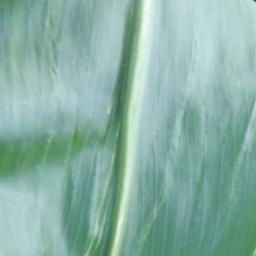

In [7]:
#getfile
!wget -O /tmp/test.jpg http://ourtestimages.s3-website-us-east-1.amazonaws.com/cornhealthy.jpg 

file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  


In [10]:
#Runinference
import json
import numpy as np

endpoint_name = 'testingendpoint'


with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - Corn_(maize)___Northern_Leaf_Blight, probability - 0.9999648332595825
